<a href="https://colab.research.google.com/github/Stubberson/project-collection/blob/main/project-collection/DL_for_GNSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNSS reflectometry data
This is a homework notebook from a TU Berlin course Deep Learning for Geodata. The notebook has been slightly modified to not give out possibly sensitive information.


see also: https://www.mdpi.com/2072-4292/15/17/4169


## Learning Objectives:

- Create a hybrid model to combine both image and tabular data
- Get to know GNSS reflectometry data


## Multi-Modal Data Architecture: Combining GNSS DDMS and Tabular Data

In this exercise, we aim to design a neural network architecture that can handle **multi-modal data**:
1. **GNSS DDMS** (image-like data) processed by a Convolutional Neural Network (CNN).
2. **Tabular Data** (e.g., SNR) processed by a Multi-Layer Perceptron (MLP).

The goal is to predict **wind speeds** from this combined data. The exercise is divided into three parts:
1. Train on DDMS (image data) only.
2. Train on tabular data only.
3. Train jointly on both data modalities.

### GNSS reflectometry

GNSS (Global Navigation Satellite System) Reflectometry involves using signals from GNSS satellites, such as GPS, to measure properties of the Earth's surface. These satellites continuously send out signals that are primarily used for navigation. In GNSS Reflectometry, these signals are not only received directly by a receiver but are also reflected off the Earth's surface (like the ocean) and then received. By analyzing the direct and the reflected signals, characteristics of the surface, such as roughness, can be deduced.

For measuring **wind speeds** over the ocean, GNSS Reflectometry is particularly useful. The roughness of the ocean surface is influenced by wind speed – higher winds result in rougher seas. The characteristics of the reflected GNSS signals change depending on this surface roughness. By analyzing changes in the Delay-Doppler Maps (DDMs), which are graphical representations of the received GNSS signals, scientists can estimate the wind speed over the ocean's surface. This method provides a valuable tool for environmental monitoring and weather forecasting.

### Delay-Doppler maps
Delay-Doppler Maps (DDMs) are graphical representations used in GNSS Reflectometry to analyze the signals reflected off the Earth's surface. These maps are created by measuring the delay and Doppler shift of the GNSS signals (like those from GPS satellites) after they bounce off a surface, such as the ocean.

    Delay: This measures the time difference between when a signal is sent from the satellite and when it is received after reflection. The delay gives information about the distance the signal has traveled.

    Doppler Shift: This is the change in frequency of the signal due to the motion of the reflecting surface relative to the satellite. It provides information about the surface's movement and roughness.

In a DDM, these two elements (delay and Doppler shift) are plotted on a grid to create a visual representation of the signal's characteristics. The shape and intensity of the patterns in a DDM can be analyzed to infer properties of the reflecting surface, such as wind speed over the ocean, by interpreting how the sea surface's roughness affects the reflected signals.


### Tabular Metadata
The Delay-Doppler maps usually come with additional measurements, such as
- NBRCS (Normalized Bistatic Radar Cross Section): This measures the strength of the signal reflected back to the satellite. NBRCS is normalized to account for varying distances and angles, providing a consistent measure of the reflectivity of the surface. In the context of ocean surfaces, it helps indicate the roughness of the sea, which is influenced by wind speed.

- LES (Leading Edge Slope): LES refers to the slope of the leading edge of the reflected signal in a DDM. It provides insights into the texture of the reflecting surface. A steeper slope can indicate a smoother surface, while a gentler slope suggests a rougher surface, like choppy water.

- EIRP (Equivalent Isotropically Radiated Power): This is a measure of the power transmitted by the satellite's antenna as if it were radiating equally in all directions. Knowing the EIRP helps in calibrating the received signal strength, which is crucial for accurately interpreting the NBRCS and LES.

- Incidence Angle: This is the angle at which the satellite's signal hits the Earth's surface. The incidence angle affects how the signal is reflected and scattered, influencing the resulting NBRCS and LES measurements.

These metadata parameters are integral in interpreting DDMs, as they provide essential context for understanding the characteristics of the reflected GNSS signals and, by extension, the properties of the Earth's surface, such as wind speeds over oceans.

In [ ]:
# Import TensorFlow
import tensorflow as tf

# Data preparation
Our dataset consists of three parts:
- the wind speeds (wind_speeds2.npy)
- the ddms (ddms2.npy)
- the additional tabular data (ddms.geojson)

## Basic EDA

In [ ]:
import numpy as np
import os
import geopandas as gpd
import tensorflow as tf

In [ ]:
# These are dummy downloads
wind_speeds = np.load('downloadable.npy')
ddms = np.load('downloadable.npy')
ddms_tabular = gpd.read_file('downloadable.geojson')

print(wind_speeds.shape,ddms.shape,ddms_tabular.shape)

(91995,) (91995, 17, 11) (91995, 12)


All datasets have the same number of samples. Wind speed data is a simple array with 91995 samples. Using np.unique, we can list all values in the dataset.

In [ ]:
np.unique(wind_speeds)

array([ 0.4927811 ,  0.49977982,  0.5055578 , ..., 22.780392  ,
       22.781809  , 22.830006  ], dtype=float32)

The DDMs have shape 17x11. We can plot them together with the wind speed information using matplotlib.

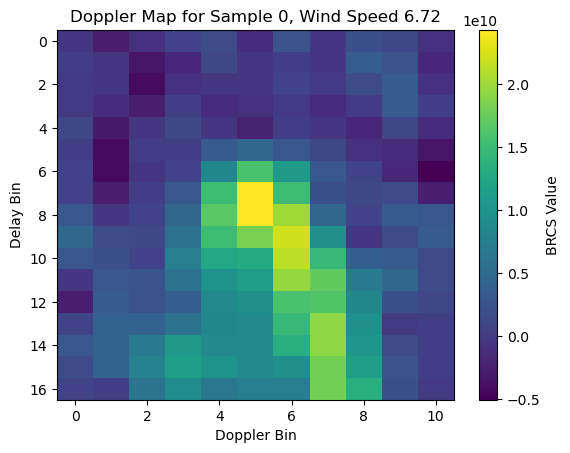

In [ ]:
import matplotlib.pyplot as plt

sample_index = 0

# Plot the Doppler map
plt.imshow(ddms[sample_index], aspect='auto')
plt.colorbar(label='BRCS Value')
plt.title(f'Doppler Map for Sample {sample_index}, Wind Speed {wind_speeds[sample_index]:.2f}')
plt.xlabel('Doppler Bin')
plt.ylabel('Delay Bin')
plt.show()

The values go up to 10 000 000 000, so we definitely need to re-scale them.

The additional features ddms_tabular are stored in a geopandas dataframe. We can look at the first rows of the table and plot the data.
Note that plotting using the explore functions requires folium to be installed. We only lot the first 1000 rows in order to keep get a fast plot.

From the table we will only select some of the columns for training (here domain expert advice would be helpful). We choose 'SNR', 'DDM_NBRCS', 'DDM_LES'.

In [ ]:
ddms_tabular.head()

,Latitude,Longitude,SNR,Noise_Floor,Antenna_Temp,Fresnel_Coeff,DDM_NBRCS,DDM_LES,NBRCS_Scatter_Area,LES_Scatter_Area,DDM_BRCS_Uncert,geometry
0,5.656870,216.423096,1.721583,7620.701172,99.400002,0.651755,25.110157,8.688427,7.172548e+09,7.172548e+09,0.432143,POINT (216.42310 5.65687)
1,5.623117,216.466095,1.789436,7629.725586,99.400002,0.651693,28.014544,7.516722,7.179782e+09,7.179782e+09,0.432143,POINT (216.46609 5.62312)
2,6.617546,222.109787,0.693101,7638.321289,99.400002,0.683861,19.317751,14.962830,3.252637e+09,3.252637e+09,0.265750,POINT (222.10979 6.61755)
3,6.617546,222.109787,0.693101,7638.321289,99.400002,0.683861,19.317751,14.962830,3.252637e+09,3.252637e+09,0.265750,POINT (222.10979 6.61755)
4,5.589362,216.509064,1.713871,7634.246582,99.400002,0.651631,23.867775,10.908248,7.187014e+09,7.187014e+09,0.432143,POINT (216.50906 5.58936)


In [ ]:
# plot first 1000 rows
ddms_tabular[:1000].explore()

## Select and Rescale Data

Wind speeds do not need to be normalized in this case. We only normalize the input.

Choose columns from the tabular data and normalize tabular data.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select the required columns
columns_to_use = ['SNR', 'DDM_NBRCS', 'DDM_LES']
ddms_selected = ddms_tabular[columns_to_use]

# Normalize the selected columns
scaler = StandardScaler()
ddms_normalized = scaler.fit_transform(ddms_selected)


In [ ]:
ddms_normalized

array([[-0.76755322,  0.15591849,  0.11211784],
       [-0.72928154,  0.27513023, -0.02391267],
       [-1.34766069, -0.08183318,  0.84055238],
       ...,
       [ 0.26070965, -0.55470107, -0.48867664],
       [ 0.13710054, -0.55085788, -0.56834713],
       [ 0.34526751, -0.47011489, -0.3177077 ]])

Also normalize the ddm images. Then we add an additional channel, which is needed for the Conv layer in the tensorflow model later.

In [ ]:
# Normalize values
ddms = (ddms - np.mean(ddms)) / np.std(ddms)

# Add additional channel to ddm images of size 17x11
ddms = ddms[:,:,:,np.newaxis]
ddms.shape

(91995, 17, 11, 1)

## Split the data into train, validation, and test

We need to split all three datasets in the same way. For this we can still use the train_test_split function and provide it with all three datasets.

In [ ]:
from sklearn.model_selection import train_test_split

X_images_temp, X_images_test, X_tabular_temp, X_tabular_test, y_temp, y_test = train_test_split(
    ddms, ddms_normalized, wind_speeds, test_size=0.2, random_state=1337) # split into test and train/val

X_images_train, X_images_val, X_tabular_train, X_tabular_val, y_train, y_val = train_test_split(
    X_images_temp, X_tabular_temp, y_temp, test_size=0.25, random_state=1337) # split train/val into actual train and val

# Training

## Train CNN on DDM images

Our target is the wind_speeds (y_train, y_val, y_test).

For this experiment we will only use the ddm images as input and ignore the tabular data.
So we will use X_images_train, X_images_val and X_images_test.


### Prepare Datasets for tensorflow
Tensorflow provides a lot of ways to create datasets. Here, we are going to use ``tf.data.Dataset.from_tensor_slices``, which creates a tensorflow dataset from our numpy arrays.

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_images_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_images_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_images_test, y_test))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_images_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2024-11-22 16:52:19.355650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14940 MB memory:  -> device: 4, name: Quadro RTX 5000, pci bus id: 0000:81:00.0, compute capability: 7.5


### Define CNN model architecture


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate, Dropout

inputs = Input(shape=(17, 11, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17, 11, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 9, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 7, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 3, 64)          0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               16640 

### Train CNN and check results

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'] )

In [ ]:
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset)

Epoch 1/15


2024-11-22 16:52:20.395706: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-11-22 16:52:21.622043: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f566d517700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 16:52:21.622108: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-11-22 16:52:21.628514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732294341.729857    8763 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1725/1725 [==============================] - 7s 3ms/step - loss: 15.1659 - mean_absolute_error: 2.9530 - val_loss: 9.0685 - val_mean_absolute_error: 2.4310
Epoch 2/15
1725/1725 [==============================] - 5s 3ms/step - loss: 9.8310 - mean_absolute_error: 2.5280 - val_loss: 7.7781 - val_mean_absolute_error: 2.2271
Epoch 3/15
1725/1725 [==============================] - 4s 2ms/step - loss: 8.7887 - mean_absolute_error: 2.3566 - val_loss: 6.8713 - val_mean_absolute_error: 2.0913
Epoch 4/15
1725/1725 [==============================] - 4s 2ms/step - loss: 8.1096 - mean_absolute_error: 2.2444 - val_loss: 6.3218 - val_mean_absolute_error: 1.9826
Epoch 5/15
1725/1725 [==============================] - 4s 2ms/step - loss: 7.5588 - mean_absolute_error: 2.1499 - val_loss: 6.1016 - val_mean_absolute_error: 1.9422
Epoch 6/15
1725/1725 [==============================] - 4s 2ms/step - loss: 7.1200 - mean_absolute_error: 2.0794 - val_loss: 6.0326 - val_mean_absolute_error: 1.8842
Epoch 7/15
172

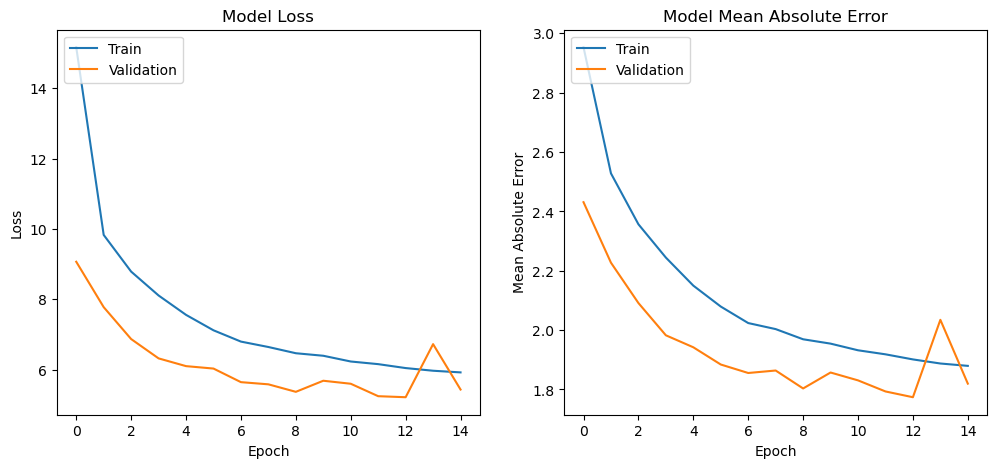

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(test_dataset)
print("mse", test_loss, "  mean absolute error",test_mae)

575/575 [==============================] - 1s 1ms/step - loss: 5.4097 - mean_absolute_error: 1.8090
mse 5.40969705581665   mean absolute error 1.8090072870254517


In order to get a better idea of the predictions, we also plot the predictions against the ground truth values.

575/575 [==============================] - 0s 752us/step


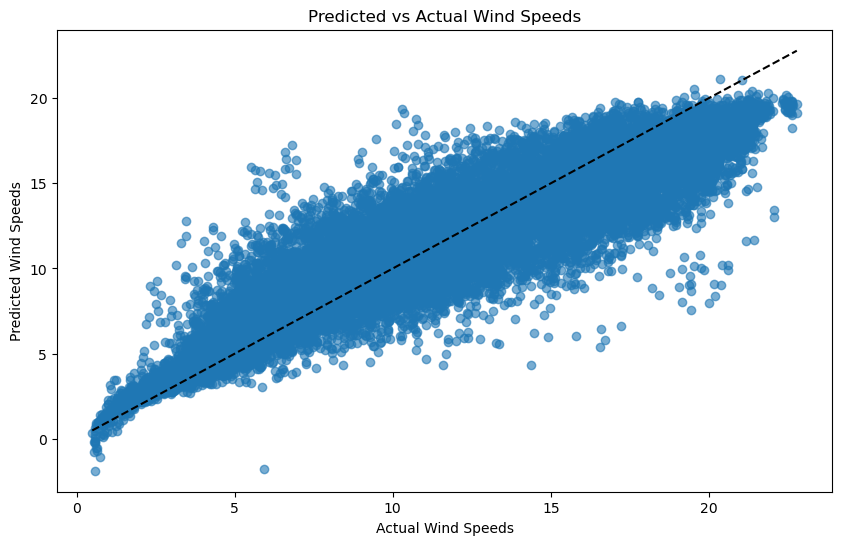

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predicted_wind_speeds = model.predict(test_dataset)

actual_wind_speeds = []
for _, wind_speed in test_dataset.unbatch():
    actual_wind_speeds.append(wind_speed.numpy())

actual_wind_speeds = np.array(actual_wind_speeds)

# Plotting predicted vs. actual wind speeds
plt.figure(figsize=(10, 6))
plt.scatter(actual_wind_speeds, predicted_wind_speeds, alpha=0.6)
plt.xlabel('Actual Wind Speeds')
plt.ylabel('Predicted Wind Speeds')
plt.title('Predicted vs Actual Wind Speeds')
plt.plot([actual_wind_speeds.min(), actual_wind_speeds.max()], [actual_wind_speeds.min(), actual_wind_speeds.max()], 'k--') # Diagonal line
plt.show()

## Train fully connected network on tabular data

For this experiment we will only use the tabular data as input and ignore the image data.
So we will use X_tabular_train, X_tabular_val and X_tabular_test.

### Prepare Datasets for tensorflow
Tensorflow provides a lot of ways to create datasets. Here, we are going to use ``tf.data.Dataset.from_tensor_slices``, which creates a tensorflow dataset from our numpy arrays.

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_tabular_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_tabular_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_tabular_test, y_test))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_tabular_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Define fully connected architecture for tabular data

In [ ]:
def get_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

model = get_model((3,)) # our tabular data has three features
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train fully connected model on tabular data

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'] )

In [ ]:
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset)

Epoch 1/15
1725/1725 [==============================] - 4s 2ms/step - loss: 9.7228 - mean_absolute_error: 2.0324 - val_loss: 4.4601 - val_mean_absolute_error: 1.6157
Epoch 2/15
1725/1725 [==============================] - 3s 2ms/step - loss: 4.2623 - mean_absolute_error: 1.5521 - val_loss: 4.1568 - val_mean_absolute_error: 1.5308
Epoch 3/15
1725/1725 [==============================] - 3s 2ms/step - loss: 4.1648 - mean_absolute_error: 1.5338 - val_loss: 4.1123 - val_mean_absolute_error: 1.5416
Epoch 4/15
1725/1725 [==============================] - 3s 2ms/step - loss: 4.1195 - mean_absolute_error: 1.5274 - val_loss: 4.1086 - val_mean_absolute_error: 1.5250
Epoch 5/15
1725/1725 [==============================] - 3s 2ms/step - loss: 4.0750 - mean_absolute_error: 1.5168 - val_loss: 4.0024 - val_mean_absolute_error: 1.4982
Epoch 6/15
1725/1725 [==============================] - 3s 2ms/step - loss: 4.0361 - mean_absolute_error: 1.5065 - val_loss: 4.0163 - val_mean_absolute_error: 1.5305
Epoc

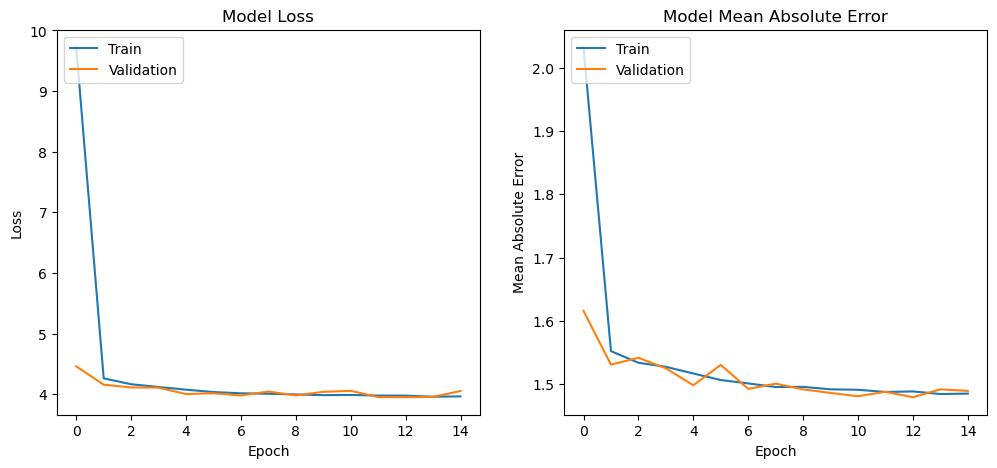

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(test_dataset)
print("mse", test_loss, "  mean absolute error",test_mae)

575/575 [==============================] - 1s 911us/step - loss: 4.0663 - mean_absolute_error: 1.4813
mse 4.066278457641602   mean absolute error 1.4813015460968018


575/575 [==============================] - 0s 646us/step


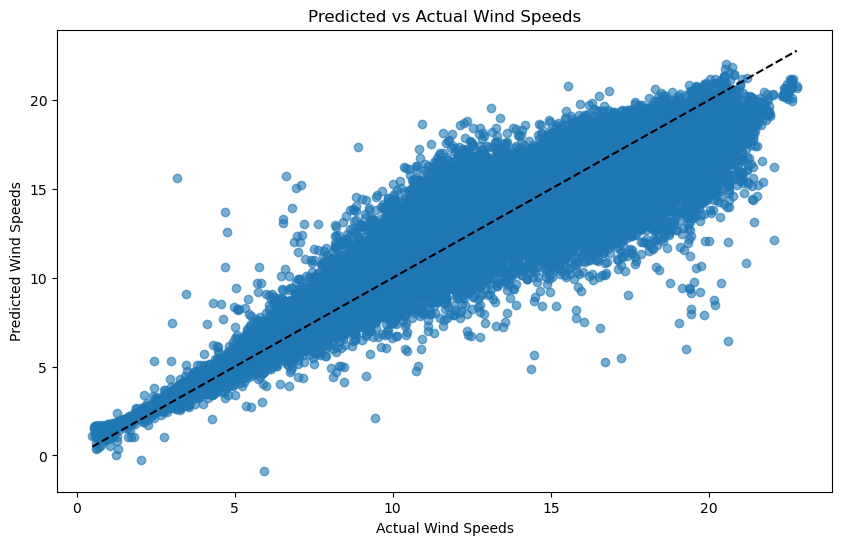

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predicted_wind_speeds = model.predict(test_dataset)

actual_wind_speeds = []
for _, wind_speed in test_dataset.unbatch():
    actual_wind_speeds.append(wind_speed.numpy())

actual_wind_speeds = np.array(actual_wind_speeds)

# Plotting predicted vs. actual wind speeds
plt.figure(figsize=(10, 6))
plt.scatter(actual_wind_speeds, predicted_wind_speeds, alpha=0.6)
plt.xlabel('Actual Wind Speeds')
plt.ylabel('Predicted Wind Speeds')
plt.title('Predicted vs Actual Wind Speeds')
plt.plot([actual_wind_speeds.min(), actual_wind_speeds.max()], [actual_wind_speeds.min(), actual_wind_speeds.max()], 'k--') # Diagonal line
plt.show()

## Train combined network on images and tabular data
Now, we will combine both networks, and use both images and tabular data. Basically, all we need to do is to remove the output layers from both networks and concatenate the features from the previous layers from both networks. Then we can add a new head and output layer.

The implementation in tensorflow is a little bit more tricky, especially as we now need to create a dataset that provides both images and tabular data. So focus more on the idea rather than the specific implementation details.


### Prepare Datasets for tensorflow
In this case, we need to write a custom generator function that provides both images and tabular data at the same time.
Then a tensorflow Dataset can be created from this generator.

The important thing is that this new dataset provides training samples of the form: ``(batch_images, batch_tabular), batch_labels``

So our model will be provides with matching ddm images, ddm tabular data and the corresponding wind speed label in a batched format.

In [ ]:
# define new generator for our custom dataset

def create_tf_dataset(images, tabular_data, labels, batch_size, shuffle=True):
    def generator():
        data_size = len(images)
        indices = np.arange(data_size)

        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, data_size, batch_size):
            end_idx = min(start_idx + batch_size, data_size)
            batch_indices = indices[start_idx:end_idx]

            batch_images = images[batch_indices]
            batch_tabular = tabular_data[batch_indices]
            batch_labels = labels[batch_indices]

            yield (batch_images, batch_tabular), batch_labels

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec(shape=(None,) + images[0].shape, dtype=tf.float32),
             tf.TensorSpec(shape=(None, tabular_data.shape[1]), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )


In [ ]:
# Instantiate the custom dataset
batch_size = 32
train_dataset = create_tf_dataset(X_images_train, X_tabular_train, y_train, batch_size, shuffle=True)
val_dataset = create_tf_dataset(X_images_val, X_tabular_val, y_val, batch_size, shuffle=True)
test_dataset = create_tf_dataset(X_images_test, X_tabular_test, y_test, batch_size, shuffle=False)

### Define combined architecture

First, we define our two partial models, one for the tabular data, one for the image data.

Note that they are both missing the output layers.

The **functional Keras API** is essential for building complex architectures like this because:
- It allows creating models with **multiple inputs and outputs**, which isn’t possible with the sequential API.
- You can **define multiple independent branches** (CNN for images and MLP for tabular data) and merge them into a single model.

In our case, we need:
1. **A CNN branch**: Processes the DDMS (image-like) data.
2. **An MLP branch**: Processes the tabular data (e.g., SNR).
3. **A combined model**: Merges the outputs of the CNN and MLP using a **concatenate layer**.


### Redefining CNN and MLP Without Heads / Output Layer

When combining models, we need to exclude their **output layers** ("heads") because the outputs of both branches need to be merged first. Instead:
- The **CNN** will produce a feature vector (using a global pooling layer or flatten).
- The **MLP** will output a feature vector directly from its dense layers.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate

### The Concatenate Layer

The **`Concatenate` layer** in Keras is used to merge the outputs of two or more branches into a single tensor. For multi-modal data, this is where the features from the CNN (image-like data) and MLP (tabular data) branches are combined.

Key points about the `Concatenate` layer:
- It **stacks feature vectors** from different branches along the last axis.
- The combined tensor can then be passed to additional layers for further processing.

**Example**:
```python
from tensorflow.keras.layers import concatenate

# Combine CNN and MLP outputs
combined = concatenate()([cnn_model, dense_model])
```

Afterwards, we need to add a new output layer.

In [ ]:
# Define the input shapes of both inputs
image_input_shape = (17, 11, 1)
tabular_input_shape = (3,)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

# Define the CNN for image processing
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    return Model(inputs, x)

# Define the dense network for tabular data
def create_dense_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    return Model(inputs, x)


# Create the two models
cnn_model = create_cnn_model(image_input_shape)
dense_model = create_dense_model(tabular_input_shape)

Then we combine the two into a new model by concatenating their outputs and adding a new output layer.

In [ ]:

# Define inputs for both types of data
image_input = Input(shape=image_input_shape)
tabular_input = Input(shape=tabular_input_shape)

# Get the outputs from both models
cnn_output = cnn_model(image_input)
dense_output = dense_model(tabular_input)

# Concatenate the outputs
concatenated = concatenate([cnn_output, dense_output])

# Add a final dense layer for prediction
output = Dense(1, activation='linear')(concatenated)

# Create the final model
model = Model(inputs=[image_input, tabular_input], outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 17, 11, 1)]          0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128)                  18816     ['input_4[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 64)                   256       ['input_5[0][0]']             
                                                                                            

### Train our combined model

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'] )

In [ ]:
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset)

Epoch 1/15
   1725/Unknown - 5s 2ms/step - loss: 8.3732 - mean_absolute_error: 1.7684

2024-11-22 16:54:25.498703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15495411812578615889
2024-11-22 16:54:25.498777: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11743555528504585073
2024-11-22 16:54:25.498788: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17948987193901376679
2024-11-22 16:54:25.498805: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7984484260313397696
2024-11-22 16:54:25.498911: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 14540891223909251870
2024-11-22 16:54:25.498932: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7176744110294418744


1725/1725 [==============================] - 5s 2ms/step - loss: 8.3732 - mean_absolute_error: 1.7684 - val_loss: 1.9324 - val_mean_absolute_error: 1.0008
Epoch 2/15
  77/1725 [>.............................] - ETA: 3s - loss: 1.7796 - mean_absolute_error: 0.9956

2024-11-22 16:54:26.192558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15495411812578615889
2024-11-22 16:54:26.192639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17948987193901376679
2024-11-22 16:54:26.192674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7984484260313397696


1725/1725 [==============================] - 4s 2ms/step - loss: 1.8193 - mean_absolute_error: 0.9632 - val_loss: 1.8087 - val_mean_absolute_error: 0.9635
Epoch 3/15
1725/1725 [==============================] - 4s 2ms/step - loss: 1.7286 - mean_absolute_error: 0.9259 - val_loss: 1.6730 - val_mean_absolute_error: 0.9051
Epoch 4/15
1725/1725 [==============================] - 4s 2ms/step - loss: 1.6530 - mean_absolute_error: 0.9002 - val_loss: 1.7494 - val_mean_absolute_error: 0.9337
Epoch 5/15
1725/1725 [==============================] - 4s 2ms/step - loss: 1.6232 - mean_absolute_error: 0.8886 - val_loss: 1.6831 - val_mean_absolute_error: 0.9111
Epoch 6/15
1725/1725 [==============================] - 4s 2ms/step - loss: 1.5798 - mean_absolute_error: 0.8727 - val_loss: 1.5711 - val_mean_absolute_error: 0.8751
Epoch 7/15
1725/1725 [==============================] - 4s 2ms/step - loss: 1.5523 - mean_absolute_error: 0.8636 - val_loss: 1.5530 - val_mean_absolute_error: 0.8625
Epoch 8/15
1725

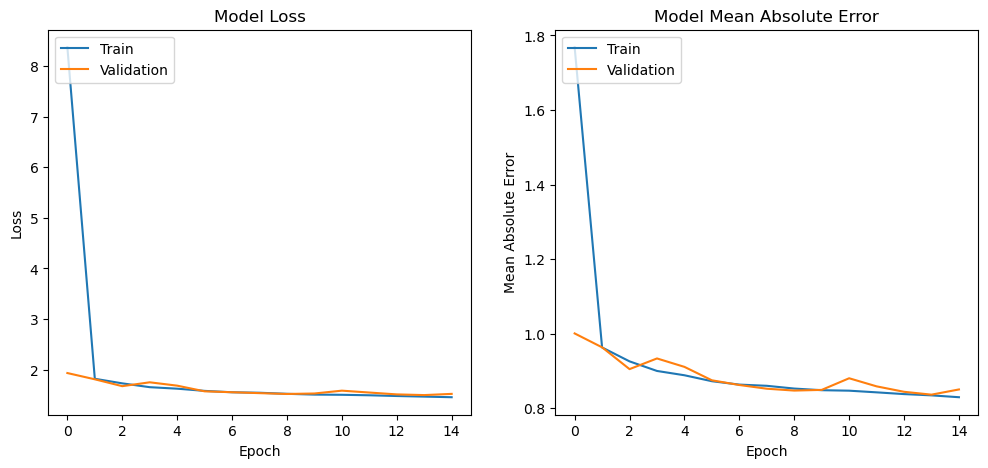

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(test_dataset)
print("mse", test_loss, "  mean absolute error",test_mae)

575/575 [==============================] - 1s 1ms/step - loss: 1.5581 - mean_absolute_error: 0.8571
mse 1.558108925819397   mean absolute error 0.857086181640625


2024-11-22 16:55:25.164654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15495411812578615889
2024-11-22 16:55:25.164718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17948987193901376679
2024-11-22 16:55:25.164739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7984484260313397696


575/575 [==============================] - 1s 823us/step


2024-11-22 16:55:25.711891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15495411812578615889
2024-11-22 16:55:25.711954: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7984484260313397696


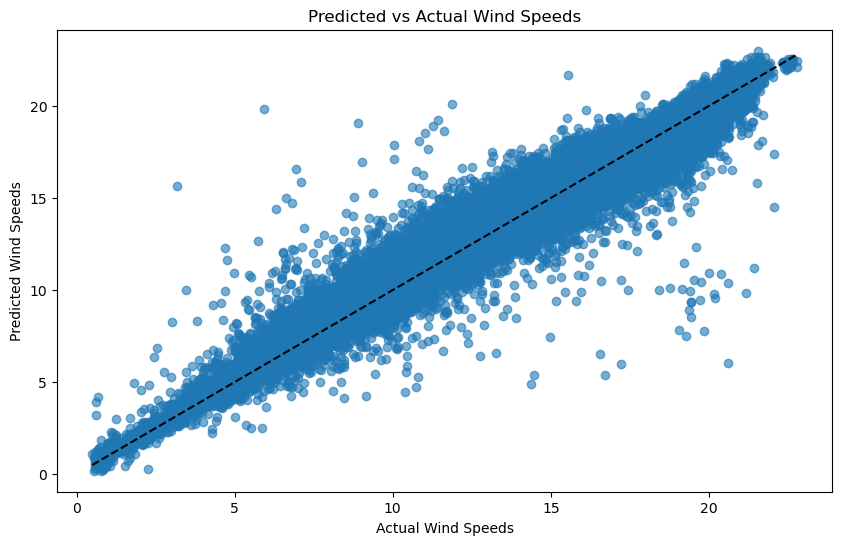

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predicted_wind_speeds = model.predict(test_dataset)

actual_wind_speeds = []
for _, wind_speed in test_dataset.unbatch():
    actual_wind_speeds.append(wind_speed.numpy())

actual_wind_speeds = np.array(actual_wind_speeds)

# Plotting predicted vs. actual wind speeds
plt.figure(figsize=(10, 6))
plt.scatter(actual_wind_speeds, predicted_wind_speeds, alpha=0.6)
plt.xlabel('Actual Wind Speeds')
plt.ylabel('Predicted Wind Speeds')
plt.title('Predicted vs Actual Wind Speeds')
plt.plot([actual_wind_speeds.min(), actual_wind_speeds.max()], [actual_wind_speeds.min(), actual_wind_speeds.max()], 'k--') # Diagonal line
plt.show()

# Conclusion
We successfully integrated a Convolutional Neural Network (CNN) with a Fully Connected (Dense) network for multi-modal data, which is quite common data geo-spatial data.

The CNN processes the spatial features of DDM images, capturing patterns and characteristics unique to this form of data. Parallelly, the Fully Connected network handles the tabular data, extracting relevant features from structured information like SNR, NBRCS, LES, and others.

We then created a unified feature set that combines spatial insights from the DDM images with the structured knowledge from the tabular data. This concatenated feature set then feeds into a final output layer, typically a Dense layer, which makes the final prediction or classification – in our case, estimating wind speeds.